# Word Vectors

En este trabajo, utilizaremos **embeddings** para resolver un problema de clasificación de texto. Los embeddings, representaciones distribuidas y vectoriales de elementos, son un concepto muy común en el mundo del deep learning. Los **word vectors** que hemos visto en clase son una representación en forma de embedding de las palabras.

Para realizar este trabajo y sacarle el máximo partido, se recomienda ver los siguientes vídeos de clase:

*   Clasificación de texto con Word Vectors.
*   Análisis de overfitting con un modelo bag of words.
*   Clasificación de texto con RNN

Vamos a utilizar el dataset **"Reuters newswire topics classification"**, disponible desde Keras de manera similar al dataset de IMDB ([ver documentación](https://keras.io/datasets/#reuters-newswire-topics-classification)).

---

Se pide:

Entrenar un modelo **utilizando embeddings** que consiga un **65% de accuracy en test (55% si usamos RNNs)**, mostrando el entrenamiento y el resultado final.
 
Tenemos varias opciones para entrenar modelos con embeddings. El alumno puede explorar más de una pero es suficiente con conseguir un modelo que alcance la accuracy requerida:

*   Utilizar una **media de embeddings** al estilo de lo visto en el vídeo *Clasificación de texto con Word Vectors*
*   Utilizar una **CNN** sobre una secuencia de word vectors. Aquí necesitamos cambiar un poco la idea de convolución para actuar sobre sequencias de vectores. Keras incluye una [Convolución en 1D](https://keras.io/layers/convolutional/#conv1d) que puede ser utilizada en este caso, con un ejemplo de uso en la documentación. Una forma de hacer funcionar este esquema sería utilizar la convolución en 1D + max pooling.
*  Utilizar una **RNN** sobre una secuencia de word vectors, al estilo de lo visto en el vídeo *Clasificación de texto con RNN*. Para este problema es un poco complicado conseguir un buen modelo con RNNs, y además es más difícil experimentar ya que las redes recurrentes son modelos lentos de entrenar. Por eso, es suficiente con alcanzar un 55% de accuracy si optamos por utilizar un modelo de este estilo. Un buen consejo es emplear una red recurrente bidireccional como se ve en el vídeo *Clasificación de texto con RNN*.



---

Dos hiperparámetros importantes a elegir en el modelo son la **longitud de las secuencias de texto** y el **tamaño del vocabulario** para los embeddings. Podéis experimentar con ambos, o utilizar los mismos que se usan en los vídeos. Nótese que, al cortar todas las secuencias para que tengan el mismo tamaño, podríamos estar perdiendo mucho texto si elegimos un tamaño de secuencia demasiado pequeño. Igualmente, si las hacemos muy largas necesitaremos más tiempo para entrenar nuestros modelos. Una buena idea consiste en explorar los datos para ver cómo suelen ser de largos los textos y encontrar un buen trade-off para el tamaño de al secuencia.



---

Los embeddings que hemos visto en los vídeos se entrenan junto al modelo.  Una técnica frecuente es inicializar estos embeddings con word-vectors pre-entrenados en un gran corpus de texto, como hemos visto en clase. Esto puede ayudar ya que nuestro modelo empieza con unos embeddings que ya encapsulan significado. Si bien no es necesario para esta práctica, podéis ver cómo usar esta técnica [en el siguiente tutorial](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html).




In [0]:
##Entrenamiento a partir del dataset "Reuter newswire topics classification"
##Aproximaciónm: embeddings.

In [60]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

import matplotlib.pyplot as plt

print(tf.__version__)

1.11.0


In [21]:
#STEP1 - OBTENCIÓN DEL DATASET

In [22]:
#Reuters newswire topics classification
#El Dataset cotiene 11.228 newswires de Reuters, etiquetadas con 46 temas/categorías. 
#Cada  noticia esta dodificada como una secuencua de "word indexes" (same conventions).
from keras.datasets import reuters
reuterdataset = keras.datasets.reuters
max_words=10000
(x_train, y_train), (x_test, y_test) = reuters.load_data(path="reuters.npz",
                                                         num_words=max_words,
                                                         skip_top=0,
                                                         maxlen=None,
                                                         test_split=0.2,
                                                         seed=113,# Para shuffle
                                                         start_char=1,
                                                         oov_char=2,
                                                         index_from=3)

In [23]:
#STEP 2  - EXPLORACIÓN DE LOS DATOS

In [24]:
print("REGISTROS DE TRAINING: {}, labels: {}".format(len(x_train), len(y_train)))
print("REGISTROS DE TEST: {}, labels: {}".format(len(x_test), len(y_test)))

REGISTROS DE TRAINING: 8982, labels: 8982
REGISTROS DE TEST: 2246, labels: 2246


In [25]:
#Los textos de newswire se conviernte a números, donde cada uno de ellos representa una palabra específica en el
#diccionario.
#Así es como se refleja
print(x_train[5])

[1, 4, 37, 38, 309, 213, 349, 1632, 48, 193, 229, 463, 28, 156, 635, 11, 82, 14, 156, 635, 11, 82, 54, 139, 16, 349, 105, 462, 311, 28, 296, 147, 11, 82, 14, 296, 147, 11, 54, 139, 342, 48, 193, 3234, 361, 122, 23, 1332, 28, 318, 942, 11, 82, 14, 318, 942, 11, 82, 54, 139, 122, 7, 105, 462, 23, 349, 28, 296, 767, 11, 82, 14, 296, 767, 11, 54, 139, 342, 229, 162, 7, 48, 193, 55, 408, 28, 258, 557, 11, 82, 14, 196, 557, 11, 82, 54, 139, 162, 7, 105, 462, 55, 349, 28, 191, 968, 11, 82, 14, 191, 785, 11, 54, 139, 17, 12]


In [26]:
#The below code shows the number of words in the first and second newswires. 
#Since inputs to a neural network must be the same length, we'll need to resolve this later.
len(x_train[18]), len(x_train[109])

(91, 58)

In [27]:
#STEP 3 - Convert the integers back to words

In [28]:
#It may be useful to know how to convert integers back to text. 
#Here, we'll create a helper function to query a dictionary object that contains the integer to string mapping:
# A dictionary mapping words to an integer index
newswires_index = reuters.get_word_index(path="reuters_word_index.json")


# The first indices are reserved. Al wordindex original, añadimos estos token especiales y les añadidos
#unos indices especiales:
newswires_index = {k:(v+3) for k,v in newswires_index.items()} 
newswires_index["<PAD>"] = 0 # padding
newswires_index["<START>"] = 1 #comienzo de cadena
newswires_index["<UNK>"] = 2  # unknown, o palabras desconocidas de nuestro vocabulario
newswires_index["<UNUSED>"] = 3
#construyo el indice al reves: si se el indice, conozco la palabra
reverse_word_index = dict([(value, key) for (key, value) in newswires_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])


In [29]:
decode_review(x_train[365])

#Imprimimos el primer valor de train
print(x_train[365])

#Imprimimos sus características
print("Num Classes", max(y_train)+1)

#Imprimimos una palabra de ejemplo que se corresponda con un indice de x_train
print(list(newswires_index .keys())[list(newswires_index .values()).index(4)])

[1, 2, 1568, 71, 8, 25, 166, 887, 42, 303, 275, 5, 102, 26, 90, 67, 21, 1041, 10, 9, 894, 175, 80, 233, 22, 147, 26, 54, 29, 208, 6, 42, 133, 499, 7, 186, 13, 4, 29, 273, 94, 284, 4, 275, 23, 606, 93, 102, 6, 823, 5, 146, 21, 93, 12, 2, 1123, 19, 6077, 18, 15, 54, 29, 17, 12]
Num Classes 46
the


In [30]:
#los token start y end, no son tan útiles aqui con wordvectors como con redes recurrentes, 
#donde ayudan a reconocer el inicio y el final del texto.
#Los unknows, se correspondern con las palabras que se eliminaron con el filtor de palabras
#más frecuentes, por lo que cuando aparence en el texto, se describien como unknow ya que no
#podemos asociarles un wordembedding donde se intenta recopilar el significado de muchas palabras
#desconocidas
#Las newswires tienen tamaño distinstos. 
#El token padding, se utilizar para homogeneizar estos tamañaños y evitar complicaciones 
#al programar modelos de redes neruronales, que necesitan valores estáticos y del mismo tamaño.
#Las newswires que tenga  mas de 256 se recortan hata ese numero. Las que no lleguen a 256, van a ser
#completadas con el token padding con un indice 0 y así, el modelo serça capaz de detectar
#que no hay nada y que simplemente es un relleno.

In [31]:
#STEP 4 - PREPARACIÓN DE LOS DATOS

In [32]:
# El array de newswires se ha de convertir a tensores antes de alimentar la red neuronal
#después. es posible crear un númoer de tendores cuya shape es max_length * num_reviews
#Se crearça una función pad-sequence que se utilizará para estandarizar las longitudes "256"

x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=newswires_index ["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=newswires_index ["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)


In [33]:
len(x_train[0]), len(x_train[1])

(256, 256)

In [37]:
max(y_train)+1

46

In [38]:
num_classes=max(y_train)+1

In [39]:
num_classes

46

In [40]:

print('Convert class vector to binary class matrix '
      '(for use with categorical_crossentropy)')
y_train_2 = keras.utils.to_categorical(y_train, num_classes)
y_test_2 = keras.utils.to_categorical(y_test, num_classes)
print('y_train shape:', y_train_2.shape)
print('y_test shape:', y_test_2.shape)

Convert class vector to binary class matrix (for use with categorical_crossentropy)
y_train shape: (8982, 46)
y_test shape: (2246, 46)


In [ ]:
#STEP 5 - CREAR EL MODELO

In [ ]:
#The layers are stacked sequentially to build the classifier:
#A.- The first layer is an Embedding layer. 
#This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. 
#These vectors are learned as the model trains. The vectors add a dimension to the output array. 
#The resulting dimensions are: (batch, sequence, embedding).
#-------------------------------------------
#B.- Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example 
#by averaging over the sequence dimension. 
#This allows the model to handle input of variable length, in the simplest way possible.
#-------------------------------------------
#C.- This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.
#-------------------------------------------
#D. Next, Dropout=0.1
#--------------------------------------------
#E.- This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.
#--------------------------------------------
#F.- Next, Dropout=0.1
#--------------------------------------------
#D.- The last layer is densely connected with 46 output nodes with softmazx activations 

In [569]:

batch_size = 64
epochs = 80
num_classes = y_test_2.shape[1]
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(max_words, 16))
model2.add(keras.layers.GlobalAveragePooling1D())
model2.add(keras.layers.Dense(16, activation = "relu"))
model2.add(keras.layers.Dropout(0.1))
model2.add(keras.layers.Dense(16, activation = "relu"))
model2.add(keras.layers.Dropout(0.1))
model2.add(keras.layers.Dense(num_classes, activation = "softmax"))
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_44 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d_44  (None, 16)                0         
_________________________________________________________________
dense_99 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_49 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_100 (Dense)            (None, 16)                272       
_________________________________________________________________
dropout_50 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_101 (Dense)            (None, 46)                782       
Total para

In [570]:

model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
#Creo el dataset de validación

In [571]:
x_val = x_train[6982:]
x_train_partial = x_train[:6982]

y_val = y_train_2[6982:]
y_train_partial = y_train_2[:6982]

In [ ]:
##STEP 6 - entreno el modelo

In [572]:
history2 = model2.fit(x_train_partial, y_train_partial,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_val, y_val),
                    verbose=1)

/Users/sergiomunoz/.local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 6982 samples, validate on 2000 samples
Epoch 1/80
6982/6982 [==============================] - 2s 336us/step - loss: 3.5278 - acc: 0.3372 - val_loss: 2.7092 - val_acc: 0.3465
Epoch 2/80
6982/6982 [==============================] - 0s 61us/step - loss: 2.4238 - acc: 0.3496 - val_loss: 2.2640 - val_acc: 0.3465
Epoch 3/80
6982/6982 [==============================] - 0s 65us/step - loss: 2.3038 - acc: 0.3519 - val_loss: 2.2088 - val_acc: 0.3465
Epoch 4/80
6982/6982 [==============================] - 0s 67us/step - loss: 2.2303 - acc: 0.3503 - val_loss: 2.1154 - val_acc: 0.3480
Epoch 5/80
6982/6982 [==============================] - 0s 67us/step - loss: 2.1056 - acc: 0.3641 - val_loss: 1.9807 - val_acc: 0.3660
Epoch 6/80
6982/6982 [==============================] - 0s 67us/step - loss: 1.9732 - acc: 0.3916 - val_loss: 1.8576 - val_acc: 0.4060
Epoch 7/80
6982/6982 [==============================] - 0s 66us/step - loss: 1.8692 - acc: 0.4391 - val_loss: 1.7734 - val_acc: 0.4620
Epoch 

Epoch 61/80
6982/6982 [==============================] - 0s 64us/step - loss: 0.6231 - acc: 0.8205 - val_loss: 1.5406 - val_acc: 0.7075
Epoch 62/80
6982/6982 [==============================] - 0s 64us/step - loss: 0.6214 - acc: 0.8174 - val_loss: 1.5679 - val_acc: 0.7095
Epoch 63/80
6982/6982 [==============================] - 0s 63us/step - loss: 0.6177 - acc: 0.8190 - val_loss: 1.5565 - val_acc: 0.7105
Epoch 64/80
6982/6982 [==============================] - 0s 63us/step - loss: 0.6016 - acc: 0.8300 - val_loss: 1.5912 - val_acc: 0.7115
Epoch 65/80
6982/6982 [==============================] - 0s 63us/step - loss: 0.5943 - acc: 0.8257 - val_loss: 1.6119 - val_acc: 0.7110
Epoch 66/80
6982/6982 [==============================] - 0s 63us/step - loss: 0.5972 - acc: 0.8240 - val_loss: 1.6301 - val_acc: 0.7140
Epoch 67/80
6982/6982 [==============================] - 0s 63us/step - loss: 0.5754 - acc: 0.8329 - val_loss: 1.5964 - val_acc: 0.7075
Epoch 68/80
6982/6982 [=========================

In [573]:
results = model2.evaluate(x_test, y_test_2)

print(results)

2246/2246 [==============================] - 0s 53us/step
[1.7721528081307958, 0.7008014247551202]


In [ ]:
#se supera el objetivo con  los datos de test ACCURACY=0.70080

In [545]:
history_dict_2 = history2.history
history_dict_2.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [546]:
history_dict_2['loss']

[3.4376376809926334,
 2.413516961684783,
 2.2842738534481537,
 2.1395790902020013,
 1.981927289811836,
 1.8557089387909522,
 1.763662829470136,
 1.6951394048248654,
 1.6380659145121927,
 1.5986450121929296,
 1.5646873195203455,
 1.5263376791372711,
 1.4921949900381546,
 1.45946713256754,
 1.4181525718513583,
 1.3891268945703257,
 1.3449979454697254,
 1.3166983829156542,
 1.2755702022698916,
 1.2487269677019024,
 1.215022654835251,
 1.1834532260655741,
 1.1444997292847525,
 1.1221479864183315,
 1.0858026400093226,
 1.0720703256092656,
 1.0524378930453548,
 1.0297929514823756,
 1.0102509167296125,
 0.9913381322923822,
 0.9812535629662427,
 0.9692825134283354,
 0.94397106424371,
 0.9231829437680928,
 0.9106730536518518,
 0.9091840323559093,
 0.8902524103634902,
 0.8719184473775854,
 0.864897012386169,
 0.8456047032699651,
 0.8445113555847557,
 0.8329282453359966,
 0.8154595180966048,
 0.8255229263481866,
 0.7940163707125327,
 0.7852026956602483,
 0.787171476078013,
 0.7762955034899186,
 0

In [547]:
history_dict_2['acc']

[0.29361214552131226,
 0.33643655113148097,
 0.3716700086106,
 0.4196505299426532,
 0.47264394154694794,
 0.5083070753365798,
 0.5375250644685203,
 0.5645946719966758,
 0.5872242910340877,
 0.5998281294928687,
 0.6064164995532498,
 0.6162990547291907,
 0.6326267545116012,
 0.6323403036379261,
 0.6399312518073917,
 0.6559725007161272,
 0.6697221426354613,
 0.6731595531195632,
 0.6816098539271283,
 0.684904038940245,
 0.6945001432339737,
 0.699656258934516,
 0.7029504439817804,
 0.7106846175710099,
 0.7201374964364379,
 0.7209968490233157,
 0.7237181323573775,
 0.724004583196905,
 0.7311658550729317,
 0.7313090805097693,
 0.7357490690175867,
 0.7393297049726739,
 0.7411916356174149,
 0.7452019478744779,
 0.7472071039645933,
 0.7440561443883141,
 0.753795474076196,
 0.7492122600803195,
 0.7602406187168134,
 0.7578057863247221,
 0.7636780292009153,
 0.7669722142481797,
 0.7704096247493555,
 0.7696934975480938,
 0.7675451160296777,
 0.7788599255227728,
 0.7771412202807219,
 0.77728444570048

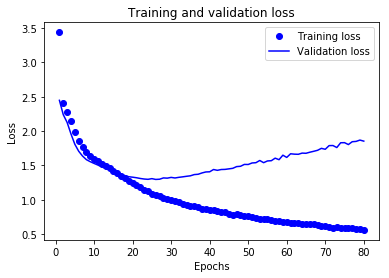

In [548]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

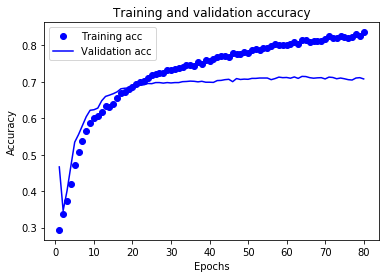

In [549]:
plt.clf()   # clear figure
acc_values = history_dict_2['acc']
val_acc_values = history_dict_2['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [61]:
x_train_pad = keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=newswires_index ["<PAD>"],
                                                        padding='post',
                                                        maxlen=512)

x_test_pad = keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=newswires_index ["<PAD>"],
                                                       padding='post',
                                                       maxlen=512)

In [62]:
len(x_train_pad[0]), len(x_train_pad[1])

(512, 512)

In [63]:
print('Convert class vector to binary class matrix '
      '(for use with categorical_crossentropy)')
y_train_pad = keras.utils.to_categorical(y_train, num_classes)
y_test_pad = keras.utils.to_categorical(y_test, num_classes)
print('y_train shape:', y_train_pad.shape)
print('y_test shape:', y_test_pad.shape)

Convert class vector to binary class matrix (for use with categorical_crossentropy)
y_train shape: (8982, 46)
y_test shape: (2246, 46)


In [64]:
#añado además una regularización tipo L2

batch_size = 64
epochs = 80
num_classes = y_test_pad.shape[1]
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(max_words, 32))
model3.add(keras.layers.GlobalAveragePooling1D())
model3.add(keras.layers.Dense(32, kernel_regularizer=keras.regularizers.l2(0.001),activation = "relu",input_shape=(max_words,)))
model3.add(keras.layers.Dropout(0.1))
model3.add(keras.layers.Dense(32,kernel_regularizer=keras.regularizers.l2(0.001), activation = "relu"))
model3.add(keras.layers.Dropout(0.1))
model3.add(keras.layers.Dense(num_classes, activation = "softmax"))
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 46)                1518      
Total para

In [65]:

model3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [66]:
x_val_pad = x_train_pad[6982:]
x_train_partial_pad = x_train_pad[:6982]

y_val_pad = y_train_pad[6982:]
y_train_partial_pad = y_train_pad[:6982]

In [67]:
history_pad = model3.fit(x_train_partial_pad, y_train_partial_pad,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_val_pad, y_val_pad),
                    verbose=1)

/Users/sergiomunoz/.local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 6982 samples, validate on 2000 samples
Epoch 1/80
6982/6982 [==============================] - 1s 144us/step - loss: 3.1948 - acc: 0.3257 - val_loss: 2.3778 - val_acc: 0.3465
Epoch 2/80
6982/6982 [==============================] - 1s 84us/step - loss: 2.3971 - acc: 0.3407 - val_loss: 2.3062 - val_acc: 0.3465
Epoch 3/80
6982/6982 [==============================] - 1s 85us/step - loss: 2.3243 - acc: 0.3510 - val_loss: 2.2404 - val_acc: 0.3470
Epoch 4/80
6982/6982 [==============================] - 1s 84us/step - loss: 2.2429 - acc: 0.3529 - val_loss: 2.1433 - val_acc: 0.3500
Epoch 5/80
6982/6982 [==============================] - 1s 85us/step - loss: 2.1243 - acc: 0.3761 - val_loss: 2.0113 - val_acc: 0.3875
Epoch 6/80
6982/6982 [==============================] - 1s 84us/step - loss: 2.0156 - acc: 0.4433 - val_loss: 1.9220 - val_acc: 0.4905
Epoch 7/80
6982/6982 [==============================] - 1s 84us/step - loss: 1.9380 - acc: 0.4820 - val_loss: 1.8610 - val_acc: 0.5230
Epoch 

Epoch 61/80
6982/6982 [==============================] - 1s 88us/step - loss: 1.1154 - acc: 0.7343 - val_loss: 1.6597 - val_acc: 0.6610
Epoch 62/80
6982/6982 [==============================] - 1s 85us/step - loss: 1.1074 - acc: 0.7352 - val_loss: 1.6704 - val_acc: 0.6605
Epoch 63/80
6982/6982 [==============================] - 1s 88us/step - loss: 1.0996 - acc: 0.7390 - val_loss: 1.6778 - val_acc: 0.6610
Epoch 64/80
6982/6982 [==============================] - 1s 85us/step - loss: 1.0888 - acc: 0.7392 - val_loss: 1.6704 - val_acc: 0.6635
Epoch 65/80
6982/6982 [==============================] - 1s 92us/step - loss: 1.0862 - acc: 0.7426 - val_loss: 1.6965 - val_acc: 0.6620
Epoch 66/80
6982/6982 [==============================] - 1s 92us/step - loss: 1.0693 - acc: 0.7458 - val_loss: 1.6907 - val_acc: 0.6615
Epoch 67/80
6982/6982 [==============================] - 1s 87us/step - loss: 1.0715 - acc: 0.7478 - val_loss: 1.6857 - val_acc: 0.6610
Epoch 68/80
6982/6982 [=========================

In [68]:
results = model3.evaluate(x_test, y_test_pad)

print(results)

2246/2246 [==============================] - 0s 16us/step
[2.126034377200839, 0.6402493321991136]


In [69]:
#Con este modelo, más complejo que el primero, también se supera el umbral pero los resultados son peores. Con lo que, 
#la premisa que existe acerca de que más capas (mayor complejidad) no siempre es mejor, se valida.

In [70]:
history_dict_pad = history_pad.history
history_dict_pad.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [71]:
history_dict_pad['loss']

[3.1947996274546,
 2.397063893870275,
 2.3242629754171094,
 2.2428666609674224,
 2.1242897488674095,
 2.015627529791179,
 1.9379966021676829,
 1.8821693805321962,
 1.8490286141813261,
 1.808139246570726,
 1.7810873735671533,
 1.7488094438150188,
 1.720208602592208,
 1.697596093366017,
 1.6735781636425227,
 1.651341095212468,
 1.632307767424123,
 1.6085689312849643,
 1.5899311763377697,
 1.5715519724415352,
 1.5557107495155214,
 1.5350066368097017,
 1.5152526598747054,
 1.5052781598815874,
 1.4905806491997138,
 1.4781854332637323,
 1.4587626539168608,
 1.4504089900123052,
 1.43677882996578,
 1.425818304317587,
 1.403347994546363,
 1.3985641276177347,
 1.385971826695672,
 1.3744789617719297,
 1.3676109103957073,
 1.3549378604268796,
 1.3380871137881034,
 1.3292856098621426,
 1.3161447924073328,
 1.3029256575908676,
 1.2969477806689576,
 1.2899846084750985,
 1.278444316796265,
 1.2686336638421392,
 1.2591300861639472,
 1.2508760328382997,
 1.241147678762683,
 1.2260574385229273,
 1.219554

In [72]:
history_dict_pad['acc']

[0.3256946433686623,
 0.3407333142408769,
 0.35104554570598817,
 0.3529074763678029,
 0.37610999715256505,
 0.4432827270123174,
 0.4819535949755384,
 0.498281294757949,
 0.5088799770839301,
 0.5209109137953608,
 0.5272128329820669,
 0.5350902320422815,
 0.5488398739701524,
 0.5590088799856209,
 0.5667430535833872,
 0.5696075623116019,
 0.5814952735435106,
 0.5846462331539374,
 0.5930965339615023,
 0.5965339444114567,
 0.5986823259810943,
 0.6077055285189358,
 0.6107132626583773,
 0.6191635634659424,
 0.6178745345344041,
 0.6256087081065598,
 0.6293325694814107,
 0.6342022343338884,
 0.6425093096704683,
 0.6422228587967931,
 0.6488112288913219,
 0.6535376683069621,
 0.6551131480951017,
 0.659123460335091,
 0.6648524778171311,
 0.6662847321684331,
 0.6681466628473217,
 0.6744485820852492,
 0.6794614723404169,
 0.6831853337152678,
 0.6824692065481537,
 0.6828988828586665,
 0.6847608135290182,
 0.6889143511716973,
 0.690919507321571,
 0.6929246634202234,
 0.6956459467030637,
 0.69979948438

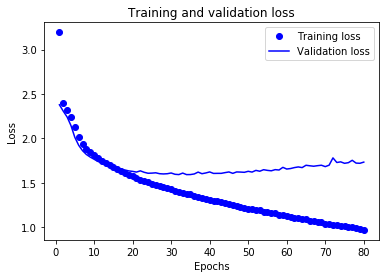

In [73]:

import matplotlib.pyplot as plt
acc = history_pad.history['acc']
val_acc = history_pad.history['val_acc']
loss = history_pad.history['loss']
val_loss = history_pad.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

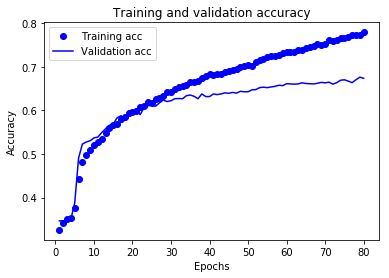

In [74]:
plt.clf()   # clear figure
acc_values = history_dict_pad['acc']
val_acc_values = history_dict_pad['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [55]:
#Los resultados son peores que en el primero de los casos.